# Prefix-Tuning 实战

## Step1 导入相关包

In [1]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForSeq2Seq, TrainingArguments, Trainer

## Step2 加载数据集

In [2]:
ds = Dataset.load_from_disk("../data/alpaca_data_zh/")
ds

Dataset({
    features: ['output', 'input', 'instruction'],
    num_rows: 26858
})

In [3]:
ds[:3]

{'output': ['以下是保持健康的三个提示：\n\n1. 保持身体活动。每天做适当的身体运动，如散步、跑步或游泳，能促进心血管健康，增强肌肉力量，并有助于减少体重。\n\n2. 均衡饮食。每天食用新鲜的蔬菜、水果、全谷物和脂肪含量低的蛋白质食物，避免高糖、高脂肪和加工食品，以保持健康的饮食习惯。\n\n3. 睡眠充足。睡眠对人体健康至关重要，成年人每天应保证 7-8 小时的睡眠。良好的睡眠有助于减轻压力，促进身体恢复，并提高注意力和记忆力。',
  '4/16等于1/4是因为我们可以约分分子分母都除以他们的最大公约数4，得到（4÷4）/ (16÷4）=1/4。分数的约分是用分子和分母除以相同的非零整数，来表示分数的一个相同的值，这因为分数实际上表示了分子除以分母，所以即使两个数同时除以同一个非零整数，分数的值也不会改变。所以4/16 和1/4是两种不同的书写形式，但它们的值相等。',
  '朱利叶斯·凯撒，又称尤利乌斯·恺撒（Julius Caesar）是古罗马的政治家、军事家和作家。他于公元前44年3月15日被刺杀。 \n\n根据历史记载，当时罗马元老院里一些参议员联合起来策划了对恺撒的刺杀行动，因为他们担心恺撒的统治将给罗马共和制带来威胁。在公元前44年3月15日（又称“3月的艾达之日”），恺撒去参加元老院会议时，被一群参议员包围并被攻击致死。据记载，他身中23刀，其中一刀最终致命。'],
 'input': ['', '输入：4/16', ''],
 'instruction': ['保持健康的三个提示。', '解释为什么以下分数等同于1/4', '朱利叶斯·凯撒是如何死亡的？']}

## Step3 数据集预处理

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Langboat/bloom-1b4-zh")
tokenizer

BloomTokenizerFast(name_or_path='Langboat/bloom-1b4-zh', vocab_size=46145, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
def process_func(example):
    MAX_LENGTH = 256
    input_ids, attention_mask, labels = [], [], []
    instruction = tokenizer("\n".join(["Human: " + example["instruction"], example["input"]]).strip() + "\n\nAssistant: ")
    response = tokenizer(example["output"] + tokenizer.eos_token)
    input_ids = instruction["input_ids"] + response["input_ids"]
    attention_mask = instruction["attention_mask"] + response["attention_mask"]
    labels = [-100] * len(instruction["input_ids"]) + response["input_ids"]
    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]
    return {
        "input_ids": input_ids, # 输入 token + 输出 token
        "attention_mask": attention_mask, # 对应的 mask（1 表示有效 token）
        "labels": labels # 在 instruction 部分都设成 -100（忽略 loss），只在 response 部分保留 token ID 作为监督信号。
    }

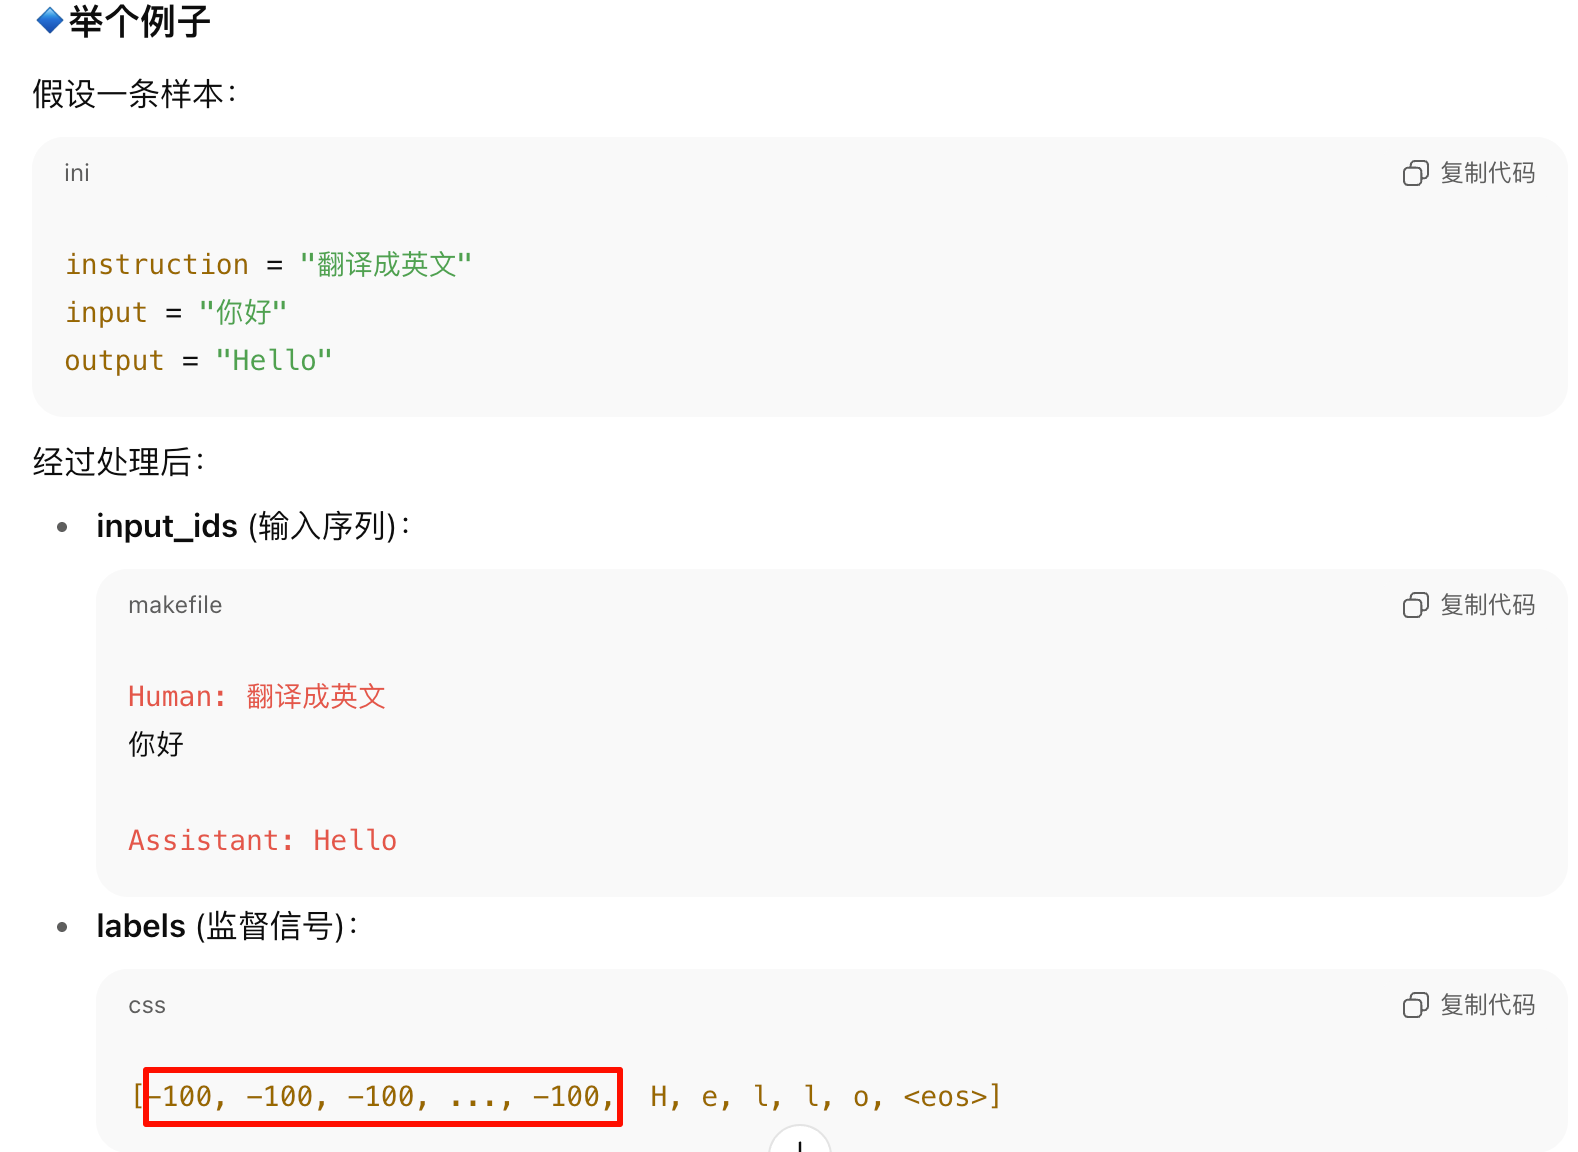
我们只希望模型学会“生成答案”，而不是去复述输入

In [ ]:
# ds.map：对数据集里的每一行都调用 process_func
tokenized_ds = ds.map(process_func, remove_columns=ds.column_names) # 原来的 ['output','input','instruction'] 三列删掉，换成 process_func 返回的三列
tokenized_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 26858
})

In [8]:
tokenizer.decode(tokenized_ds[1]["input_ids"])

'Human: 解释为什么以下分数等同于1/4\n输入：4/16\n\nAssistant: 4/16等于1/4是因为我们可以约分分子分母都除以他们的最大公约数4，得到（4÷4）/ (16÷4）=1/4。分数的约分是用分子和分母除以相同的非零整数，来表示分数的一个相同的值，这因为分数实际上表示了分子除以分母，所以即使两个数同时除以同一个非零整数，分数的值也不会改变。所以4/16 和1/4是两种不同的书写形式，但它们的值相等。</s>'

In [9]:
tokenizer.decode(list(filter(lambda x: x != -100, tokenized_ds[1]["labels"])))

'4/16等于1/4是因为我们可以约分分子分母都除以他们的最大公约数4，得到（4÷4）/ (16÷4）=1/4。分数的约分是用分子和分母除以相同的非零整数，来表示分数的一个相同的值，这因为分数实际上表示了分子除以分母，所以即使两个数同时除以同一个非零整数，分数的值也不会改变。所以4/16 和1/4是两种不同的书写形式，但它们的值相等。</s>'

## Step4 创建模型

In [10]:
model = AutoModelForCausalLM.from_pretrained("Langboat/bloom-1b4-zh")

## Prefix-tuning

### PEFT Step1 配置文件

In [11]:
from peft import PrefixTuningConfig, get_peft_model, TaskType

config = PrefixTuningConfig(task_type=TaskType.CAUSAL_LM, num_virtual_tokens=10, prefix_projection=True)
config

PrefixTuningConfig(peft_type=<PeftType.PREFIX_TUNING: 'PREFIX_TUNING'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=<TaskType.CAUSAL_LM: 'CAUSAL_LM'>, inference_mode=False, num_virtual_tokens=10, token_dim=None, num_transformer_submodules=None, num_attention_heads=None, num_layers=None, encoder_hidden_size=None, prefix_projection=True)

### PEFT Step2 创建模型

In [12]:
model = get_peft_model(model, config)

In [13]:
model.prompt_encoder

ModuleDict(
  (default): PrefixEncoder(
    (embedding): Embedding(10, 2048)
    (transform): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=True)
      (1): Tanh()
      (2): Linear(in_features=2048, out_features=98304, bias=True)
    )
  )
)

In [14]:
model.print_trainable_parameters()

trainable params: 205,641,728 || all params: 1,508,753,408 || trainable%: 13.6299


## Step5 配置训练参数

In [15]:
args = TrainingArguments(
    output_dir="./chatbot",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    logging_steps=10,
    num_train_epochs=1
)

## Step6 创建训练器

In [16]:
trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    train_dataset=tokenized_ds,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True),
)

## Step7 模型训练

In [17]:
trainer.train()

  0%|          | 0/3357 [00:00<?, ?it/s]

RuntimeError: Placeholder storage has not been allocated on MPS device!

## Step8 模型推理

In [ ]:
model = model.cuda()
ipt = tokenizer("Human: {}\n{}".format("考试有哪些技巧？", "").strip() + "\n\nAssistant: ", return_tensors="pt").to(model.device)
# do_sample=True：启用采样（不是贪心解码），会有一定随机性 skip_special_tokens=True 表示去掉 <pad>, <bos>, <eos> 等特殊标记。
# **：用于解包 字典，传给函数的 关键字参数
tokenizer.decode(model.generate(**ipt, max_length=128, do_sample=True)[0], skip_special_tokens=True)